# Tohoku tsunami inversion

Just consider P02, P06 and 80x

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.optimize as so

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock, NonlinearVariationalSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

### Forward model

In [7]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.end_time = 60*30

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [7]:
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1

In [8]:
b = Function(P1, name="Bathymetry (from ETOPO1)").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))

In this case we choose $\Gamma_{\mathrm{freeslip}}=\partial\Omega$ and $\Gamma_D=\Gamma_{100}$.

In [9]:
boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

In [10]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)
q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

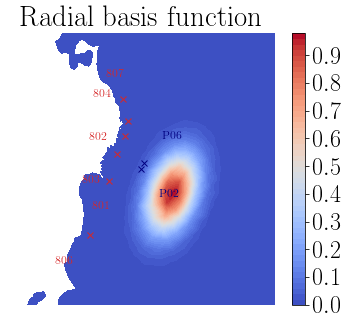

In [11]:
R = FunctionSpace(mesh, "R", 0)
optimum = 5.0
m = Function(R).assign(optimum)

basis_function = Function(TaylorHood)
psi, phi = basis_function.split()

loc = (0.7e+06, 4.2e+06)
radii = (48e+03, 96e+03)
angle = pi/12
phi.interpolate(gaussian([loc + radii, ], mesh, rotation=angle))
phi.dat.name = "Radial basis function"

axes = plot_field(phi);
xg, yg = op.gauges["P02"]["coords"]
axes.set_xlim([xg - 0.3e+06, xg + 0.3e+06]);
axes.set_ylim([yg - 0.35e+06, yg + 0.35e+06]);
op.annotate_plot(axes)

In [74]:
def solve_forward(control, store=False, keep=False, verbose=True,):
    q_.project(control*basis_function);
    
    for gauge in gauges:
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff'] = []
        op.gauges[gauge]['timeseries_smooth'] = []
        op.gauges[gauge]['diff_smooth'] = []
        op.gauges[gauge]['init'] = None
        if store:
            op.gauges[gauge]['data'] = []
        op.gauges[gauge]['adjoint_free'] = 0.0
    if keep:
        u_, eta_ = q_.split()
        op.eta_saved = [eta_.copy(deepcopy=True)]

    t = 0.0
    iteration = 0
    J = 0
    weight = Constant(1.0)
    eta_obs = Constant(0.0)
    while t < op.end_time:
        if verbose:
            print("t = {:.1f} minutes".format(t/60))

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt else 1.0)
        u, eta = q.split()
        for gauge in op.gauges:

            # Point evaluation at gauges
            eta_discrete = eta.at(op.gauges[gauge]["coords"])
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta_discrete
            eta_discrete -= op.gauges[gauge]['init']
            op.gauges[gauge]['timeseries'].append(eta_discrete)
            if store:
                op.gauges[gauge]['data'].append(eta_discrete)
            else:
                eta_obs.assign(op.gauges[gauge]['data'][iteration])
                
                # Discrete form of error
                diff = eta_discrete - eta_obs.dat.data[0]
                op.gauges[gauge]['diff'].append(diff)

                # Continuous form of error
                I = op.gauges[gauge]['indicator']
                diff = eta - eta_obs
                J += assemble(0.5*I*weight*dtc*diff*diff*dx)
                op.gauges[gauge]['adjoint_free'] += assemble(I*weight*dtc*diff*eta*dx, annotate=False)
                op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx, annotate=False))
                op.gauges[gauge]['timeseries_smooth'].append(assemble(I*eta_obs*dx, annotate=False))

        if keep:
            op.eta_saved.append(eta.copy(deepcopy=True))
                
        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    if verbose:
        print("t = {:.1f} minutes".format(t/60))
    return None if store else J

# Gauge indicators

In [13]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,), ], mesh), P0)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/assemble(op.gauges[gauge]['indicator']*dx))

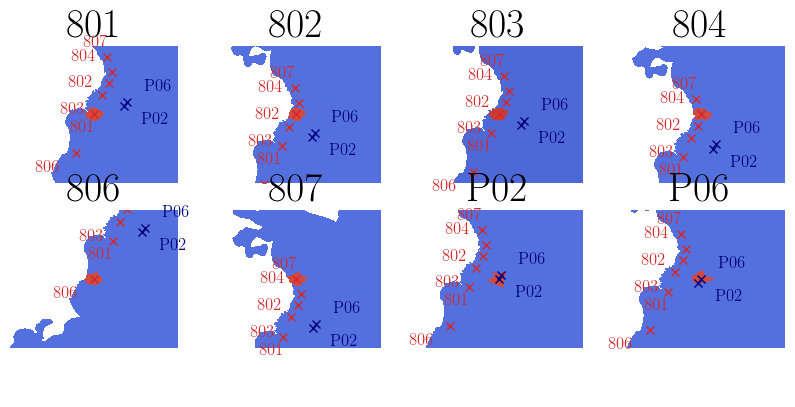

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(10, 4), dpi=100)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    tc = tricontourf(op.gauges[gauge]['indicator'], axes=ax, cmap='coolwarm')
    xg, yg = op.gauges[gauge]["coords"]
    ax.set_xlim([xg - 0.2e+06, xg + 0.2e+06]);
    ax.set_ylim([yg - 0.25e+06, yg + 0.25e+06]);
    ax.set_title(gauge)
    op.annotate_plot(ax, coords='utm')
    ax.axis(False)

In [15]:
times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
with stop_annotating():
    solve_forward(m, store=True)
    for gauge in gauges:
        op.gauges[gauge]['interpolator'] = si.interp1d(times, op.gauges[gauge]['timeseries'])

t = 0.0 minutes
t = 1.0 minutes
t = 2.0 minutes
t = 3.0 minutes
t = 4.0 minutes
t = 5.0 minutes
t = 6.0 minutes
t = 7.0 minutes
t = 8.0 minutes
t = 9.0 minutes
t = 10.0 minutes
t = 11.0 minutes
t = 12.0 minutes
t = 13.0 minutes
t = 14.0 minutes
t = 15.0 minutes
t = 16.0 minutes
t = 17.0 minutes
t = 18.0 minutes
t = 19.0 minutes
t = 20.0 minutes
t = 21.0 minutes
t = 22.0 minutes
t = 23.0 minutes
t = 24.0 minutes
t = 25.0 minutes
t = 26.0 minutes
t = 27.0 minutes
t = 28.0 minutes
t = 29.0 minutes
t = 30.0 minutes


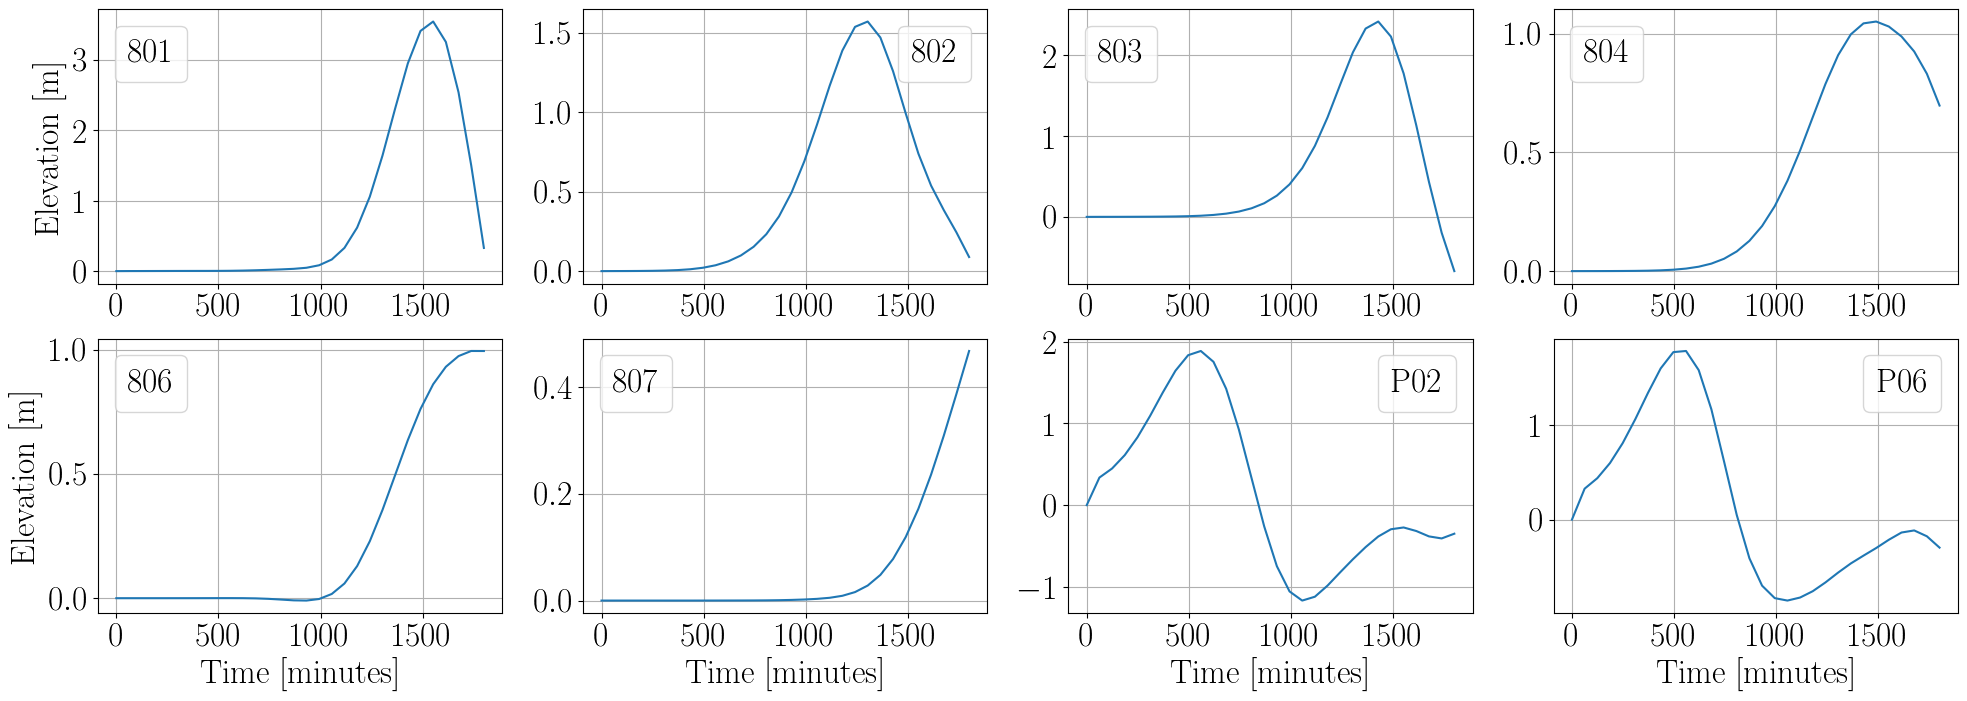

In [16]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)
t = np.linspace(0, op.end_time, 150)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times, op.gauges[gauge]['data'], label=gauge)
    ax.legend(handlelength=0, handletextpad=0)
    ax.grid(True)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")

In [17]:
# m.assign(5.0)
m.assign(10.0)
J = solve_forward(m)
print("Quantity of interest = {:.4e}".format(J))

t = 0.0 minutes
t = 1.0 minutes
t = 2.0 minutes
t = 3.0 minutes
t = 4.0 minutes
t = 5.0 minutes
t = 6.0 minutes
t = 7.0 minutes
t = 8.0 minutes
t = 9.0 minutes
t = 10.0 minutes
t = 11.0 minutes
t = 12.0 minutes
t = 13.0 minutes
t = 14.0 minutes
t = 15.0 minutes
t = 16.0 minutes
t = 17.0 minutes
t = 18.0 minutes
t = 19.0 minutes
t = 20.0 minutes
t = 21.0 minutes
t = 22.0 minutes
t = 23.0 minutes
t = 24.0 minutes
t = 25.0 minutes
t = 26.0 minutes
t = 27.0 minutes
t = 28.0 minutes
t = 29.0 minutes
t = 30.0 minutes
Quantity of interest = 1.0874e+04


Having run the forward model, we can compare the initial and final solution, as well as the discrete and continuous versions of the timeseries.

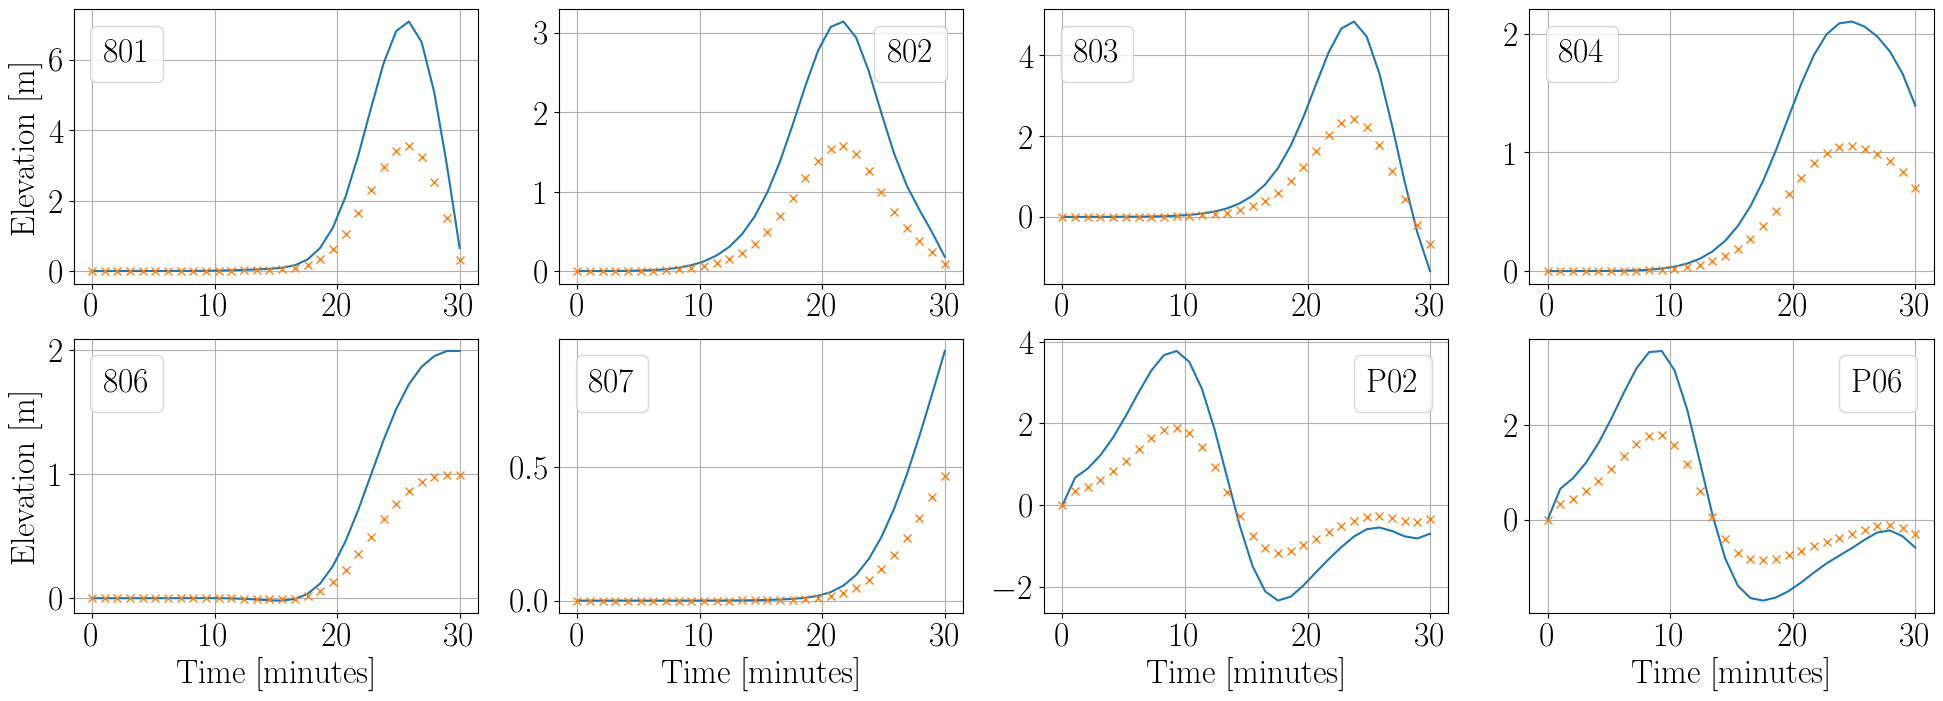

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)

for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times/60, op.gauges[gauge]['timeseries'], label=gauge)
    ax.plot(times/60, op.gauges[gauge]['data'], 'x')
    ax.legend(handlelength=0, handletextpad=0)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")
    ax.grid(True)

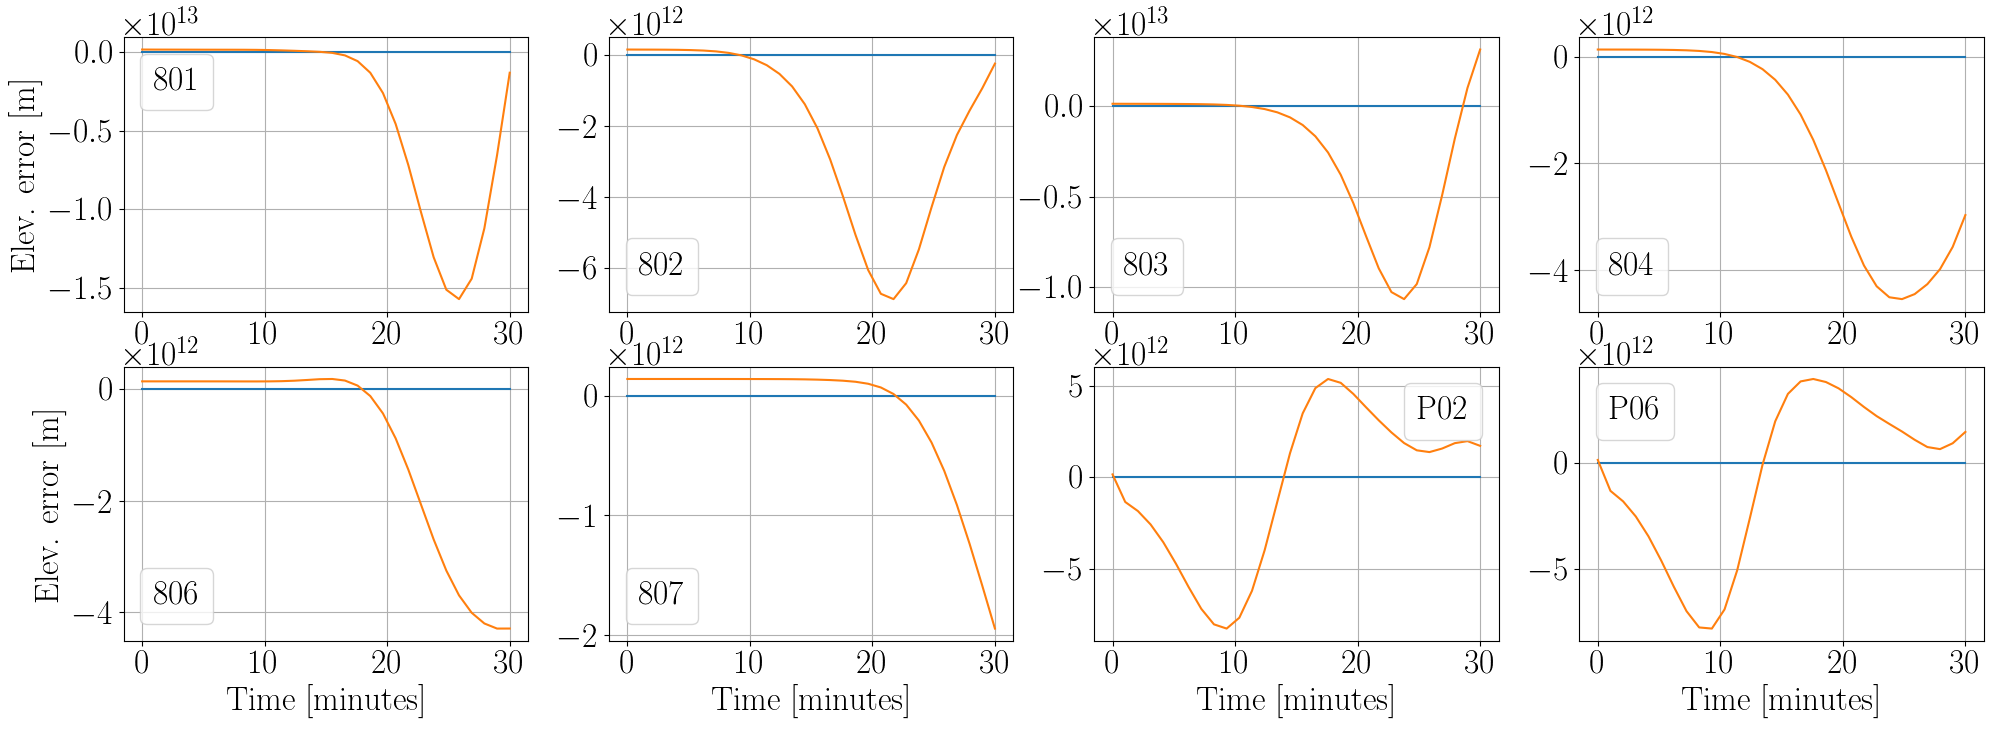

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)

for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times/60, op.gauges[gauge]['diff'], label=gauge, color='C0')
    ax.plot(times/60, op.gauges[gauge]['diff_smooth'], color='C1')
    if i >= 4:
        ax.set_xlabel('Time [minutes]')
    if i%4 == 0:
        ax.set_ylabel('Elev. error [m]')
    ax.legend(handlelength=0, handletextpad=0)
    ax.grid(True)

## Discrete adjoint

During the forward solve, pyadjoint annotated to the tape, meaning we can compute the gradient using its inbuilt automatic differentiation functionality.

In [20]:
c = Control(m)
g_discrete = compute_gradient(J, c)
print("Gradient computed using discrete adjoint at m={:.0f}: {:.8f}".format(m.dat.data[0], g_discrete.dat.data[0]))

Gradient computed using discrete adjoint at m=10: 2642.28777754


In [21]:
stop_annotating();

In [22]:
tape = get_working_tape()
solve_blocks = [block for block in tape.get_blocks() if isinstance(block, (SolveVarFormBlock, NonlinearVariationalSolveBlock))]

In [23]:
g_by_hand_discrete = assemble(phi*solve_blocks[0].adj_sol.split()[1]*dx)
print("Gradient computed using discrete adjoint formula at m={:.0f}: {:.8f}".format(m.dat.data[0], g_by_hand_discrete))

Gradient computed using discrete adjoint formula at m=10: 2642.28777754


In [24]:
g_adjoint_free = sum([op.gauges[gauge]['adjoint_free'] for gauge in gauges])/m.dat.data[0]
print("Gradient computed using adjoint free formula at m={:.0f}: {:.8f}".format(m.dat.data[0], g_adjoint_free))

Gradient computed using adjoint free formula at m=10: 2642.28752979


# Continuous adjoint

In [25]:
u_star, eta_star = TrialFunctions(TaylorHood)
q_star_ = Function(TaylorHood)
u_star_, eta_star_ = q_star_.split()

# NOTE: Time runs backwards
a_star = inner(z, u_star)*dx
L_star = inner(z, u_star_)*dx
a_star += inner(zeta, eta_star)*dx
L_star += inner(zeta, eta_star_)*dx

def G_star(uv_star, elev_star):
    F = -b*inner(z, grad(elev_star))*dx
    F += -f*inner(z, as_vector((-uv_star[1], uv_star[0])))*dx
    F += g*inner(grad(zeta), uv_star)*dx
    for tag in boundary_conditions:
        if "dirichlet" in boundary_conditions[tag]:
            F += -inner(zeta*n, uv_star)*ds(tag)
    return F

a_star += 0.5*dtc*G_star(u_star, eta_star)
L_star += -0.5*dtc*G_star(u_star_, eta_star_)

rhs = Function(P1)

L_star += dtc*zeta*rhs*dx

q_star = Function(TaylorHood)
u_star, eta_star = q_star.split()

adj_bcs = []
for tag in boundary_conditions:
    if "freeslip" not in boundary_conditions[tag]:
        adj_bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

adj_problem = LinearVariationalProblem(a_star, L_star, q_star, bcs=adj_bcs)
adj_solver = LinearVariationalSolver(adj_problem, solver_parameters=params)

In [26]:
for gauge in gauges:
    op.gauges[gauge]['obs'] = Constant(0.0)

In [59]:
def compute_gradient_continuous(control, fwd=True):
    if fwd:
        solve_forward(control, keep=True)
    iteration = int(op.end_time/op.dt)
    t = op.end_time
    while t > 0.0:
        if fwd:
            print("t = {:.1f} minutes".format(t/60))

        # Evaluate function appearing in RHS
        eta_saved = op.eta_saved[iteration]
        for gauge in gauges:
            op.gauges[gauge]['obs'].assign(op.gauges[gauge]['data'][iteration-1])
        rhs.interpolate(sum(op.gauges[g]['indicator']*(eta_saved - op.gauges[g]['obs']) for g in gauges))
        
        # Solve adjoint equation at current timestep
        adj_solver.solve()

        # Increment
        q_star_.assign(q_star)
        t -= op.dt
        iteration -= 1

    assert np.allclose(t, 0.0)
    if fwd:
        print("t = {:.1f} minutes".format(t/60))
    
    return assemble(phi*eta_star*dx)

In [57]:
g_by_hand_continuous = compute_gradient_continuous(m)
print("Gradient computed using continuous adjoint formula at m={:.0f}: {:.8f}".format(m.dat.data[0], g_by_hand_continuous))

t = 0.0 minutes
t = 1.0 minutes
t = 2.0 minutes
t = 3.0 minutes
t = 4.0 minutes
t = 5.0 minutes
t = 6.0 minutes
t = 7.0 minutes
t = 8.0 minutes
t = 9.0 minutes
t = 10.0 minutes
t = 11.0 minutes
t = 12.0 minutes
t = 13.0 minutes
t = 14.0 minutes
t = 15.0 minutes
t = 16.0 minutes
t = 17.0 minutes
t = 18.0 minutes
t = 19.0 minutes
t = 20.0 minutes
t = 21.0 minutes
t = 22.0 minutes
t = 23.0 minutes
t = 24.0 minutes
t = 25.0 minutes
t = 26.0 minutes
t = 27.0 minutes
t = 28.0 minutes
t = 29.0 minutes
t = 30.0 minutes
t = 30.0 minutes
t = 29.0 minutes
t = 28.0 minutes
t = 27.0 minutes
t = 26.0 minutes
t = 25.0 minutes
t = 24.0 minutes
t = 23.0 minutes
t = 22.0 minutes
t = 21.0 minutes
t = 20.0 minutes
t = 19.0 minutes
t = 18.0 minutes
t = 17.0 minutes
t = 16.0 minutes
t = 15.0 minutes
t = 14.0 minutes
t = 13.0 minutes
t = 12.0 minutes
t = 11.0 minutes
t = 10.0 minutes
t = 9.0 minutes
t = 8.0 minutes
t = 7.0 minutes
t = 6.0 minutes
t = 5.0 minutes
t = 4.0 minutes
t = 3.0 minutes
t = 2.0 minute

# Taylor test for discrete adjoint

In [29]:
Jhat = ReducedFunctional(J, c)

In [30]:
m0 = Function(R).assign(10.0)
dm0 = Function(R).assign(0.1)
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
epsilon 1.0000e-02  residual 1.7405e-04
epsilon 5.0000e-03  residual 3.5074e-05
epsilon 2.5000e-03  residual 4.5493e-06
epsilon 1.2500e-03  residual 9.7224e-07
Computed residuals: [0.00017404803631082544, 3.507378265354966e-05, 4.54932062787794e-06, 9.722421378532964e-07]
Computed convergence rates: [2.3110206004743725, 2.946670009565376, 2.2262635484445656]


# Optimisation for discrete adjoint

In [31]:
op.control_trajectory = []
op.functional_trajectory = []
op.gradient_trajectory = []
op.line_search_trajectory = []

def cb_post(j, dj, mm):
    op.control_trajectory.append(mm.dat.data[0])
    op.functional_trajectory.append(j)
    op.gradient_trajectory.append(dj.dat.data[0])
    print("control {:12.8f} functional {:15.8e} gradient {:15.8e}".format(mm.dat.data[0], j, dj.dat.data[0]))

Jhat = ReducedFunctional(J, c, derivative_cb_post=cb_post)

def cb(mm):
    op.line_search_trajectory.append(mm[0])
    print("Line search complete")

In [32]:
c.assign(10.0)
m_opt = minimize(Jhat, method='BFGS', callback=cb, options={'gtol': 1.0e-08})

control  10.00012500 functional  1.08742755e+04 gradient  2.64230629e+03
control   8.99012500 functional  8.41754258e+03 gradient  2.22255478e+03
Line search complete
control   6.75728894 functional  4.49097042e+03 gradient  1.29459882e+03
Line search complete
control   3.64224142 functional  2.47462902e+03 gradient -6.24197303e-04
Line search complete
control   3.64224293 functional  2.47462902e+03 gradient -6.51706672e-10
Line search complete
Optimization terminated successfully.
         Current function value: 2474.629020
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


In [33]:
i = 0
indices = [0]
for j, ctrl in enumerate(op.control_trajectory):
    if i == len(op.line_search_trajectory):
        break
    if np.isclose(ctrl, op.line_search_trajectory[i]):
        indices.append(j)
        i += 1

In [34]:
op.control_trajectory = [op.control_trajectory[i] for i in indices]
op.functional_trajectory = [op.functional_trajectory[i] for i in indices]
op.gradient_trajectory = [op.gradient_trajectory[i] for i in indices]

In [35]:
np.save('data/opt_progress_discrete_{:d}_ctrl'.format(level), op.control_trajectory)
np.save('data/opt_progress_discrete_{:d}_func'.format(level), op.functional_trajectory)
np.save('data/opt_progress_discrete_{:d}_grad'.format(level), op.gradient_trajectory)

In [40]:
op.control_trajectory = np.load('data/opt_progress_discrete_{:d}_ctrl.npy'.format(level))
op.functional_trajectory = np.load('data/opt_progress_discrete_{:d}_func.npy'.format(level))
op.gradient_trajectory = np.load('data/opt_progress_discrete_{:d}_grad.npy'.format(level))

Exact gradient at 10.0: 2642.2315
Exact gradient at  5.0: 564.2646


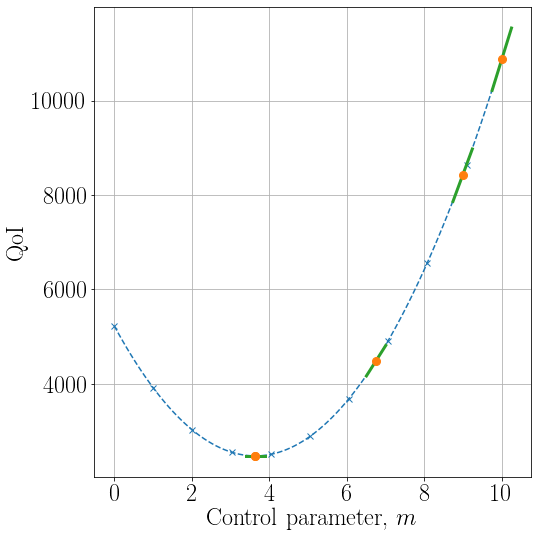

In [49]:
fig, axes = plt.subplots(figsize=(8, 8))
l = si.lagrange(op.control_trajectory[:3], op.functional_trajectory[:3])
dl = l.deriv()
print("Exact gradient at 10.0: {:.4f}".format(dl(10.0)))
print("Exact gradient at  5.0: {:.4f}".format(dl(5.0)))
l_min = -dl.coefficients[1]/dl.coefficients[0]
print("Minimiser of quadratic: {:.4f}".format(l_min))
xx = np.linspace(0, 10, 100)
axes.plot(xx, l(xx), '--x', color='C0', markevery=10)
delta_m = 0.25
for m, f, g in zip(op.control_trajectory, op.functional_trajectory, op.gradient_trajectory):
    x = np.array([m - delta_m, m + delta_m])
    axes.plot(x, g*(x-m) + f, '-', color='C2', linewidth=3)
axes.plot(op.control_trajectory, op.functional_trajectory, 'o', color='C1', markersize=8)
axes.set_xlabel(r"Control parameter, $m$")
axes.set_ylabel("QoI")
axes.grid(True)
plt.tight_layout()
plt.savefig("plots/opt_progress_discrete_{:d}.pdf".format(level))

In [37]:
J = solve_forward(m_opt)
print("Quantity of interest = {:.4e}".format(J))

t = 0.0 minutes
t = 1.0 minutes
t = 2.0 minutes
t = 3.0 minutes
t = 4.0 minutes
t = 5.0 minutes
t = 6.0 minutes
t = 7.0 minutes
t = 8.0 minutes
t = 9.0 minutes
t = 10.0 minutes
t = 11.0 minutes
t = 12.0 minutes
t = 13.0 minutes
t = 14.0 minutes
t = 15.0 minutes
t = 16.0 minutes
t = 17.0 minutes
t = 18.0 minutes
t = 19.0 minutes
t = 20.0 minutes
t = 21.0 minutes
t = 22.0 minutes
t = 23.0 minutes
t = 24.0 minutes
t = 25.0 minutes
t = 26.0 minutes
t = 27.0 minutes
t = 28.0 minutes
t = 29.0 minutes
t = 30.0 minutes
Quantity of interest = 2.4746e+03


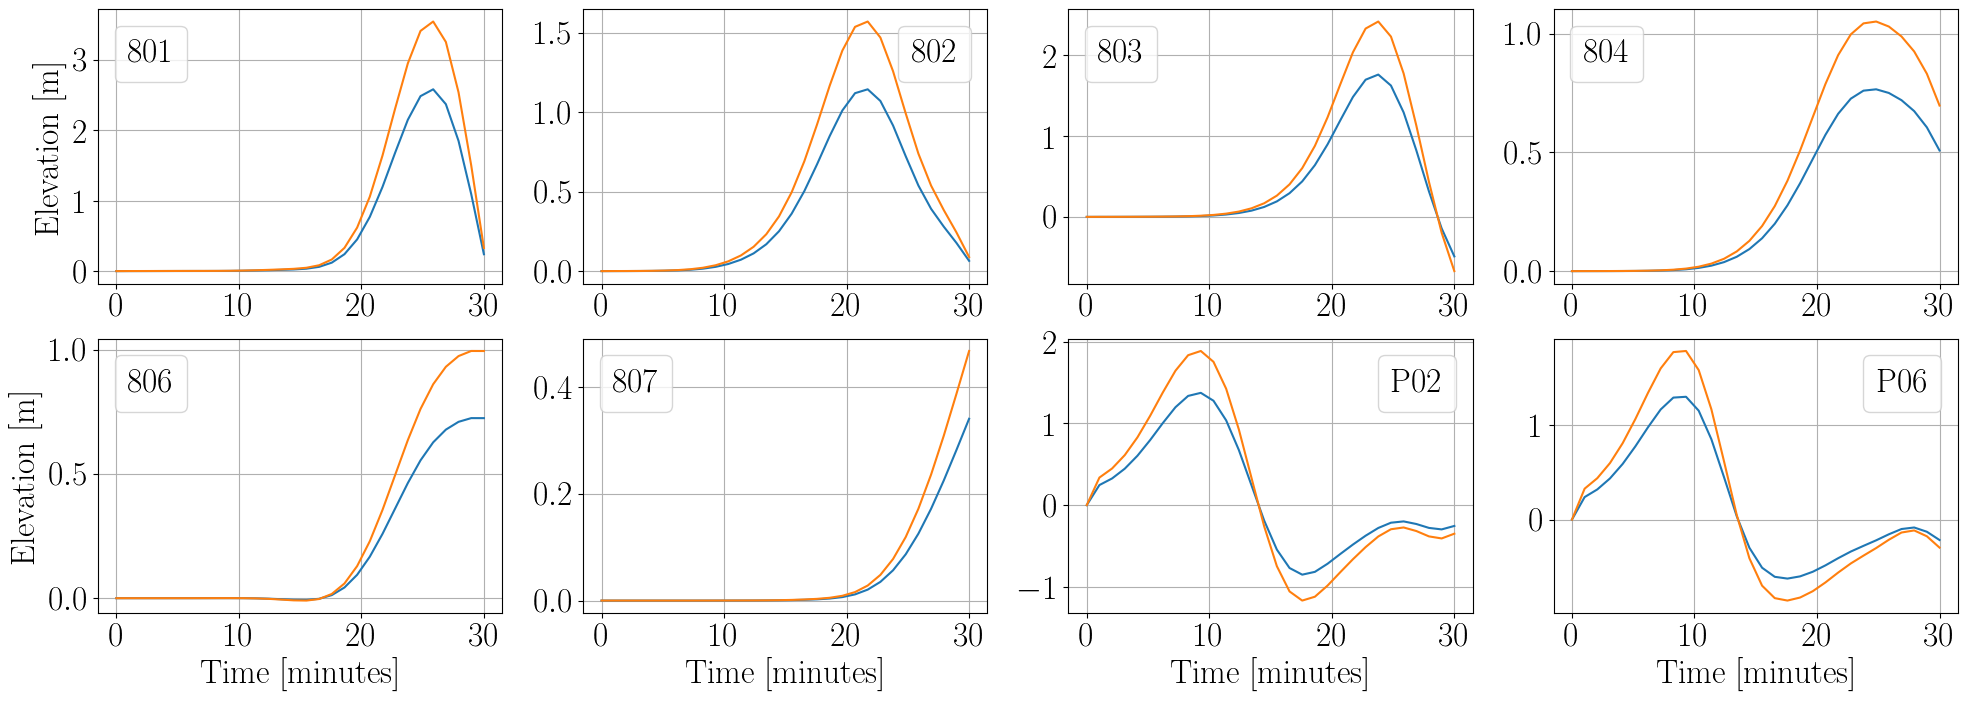

In [38]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)

times = np.array(times)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times/60, op.gauges[gauge]['timeseries'], label=gauge)
    ax.plot(times/60, op.gauges[gauge]['data'])
    ax.legend(handlelength=0, handletextpad=0)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")
    ax.grid(True)

Taylor test at 'optimum'

In [39]:
m0.assign(m_opt)
dm0.assign(0.1)
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

control   3.64224293 functional  2.47462902e+03 gradient -6.51706672e-10
Running Taylor test
epsilon 1.0000e-02  residual 2.0368e-04
epsilon 5.0000e-03  residual 4.9889e-05
epsilon 2.5000e-03  residual 1.1958e-05
epsilon 1.2500e-03  residual 2.7320e-06
Computed residuals: [0.00020367545604727552, 4.988931492178338e-05, 1.195755492439254e-05, 2.732003476530629e-06]
Computed convergence rates: [2.029469374955, 2.060808440406656, 2.1298911934401414]


# Optimisation for continuous adjoint

In [60]:
m.assign(10.0)

Constant(FiniteElement('Real', None, 0), 87492)

In [75]:
op.control_trajectory = []
op.functional_trajectory = []
op.gradient_trajectory = []
op.line_search_trajectory = []

def continuous_rf(control):
    tmp = Function(R).assign(control[0])
    op._J = solve_forward(tmp, keep=True, verbose=False)
    print("control {:12.8f} functional {:15.8e}".format(control[0], op._J))
    return op._J

def continuous_gradient(control):
    tmp = Function(R).assign(control[0])
    g = compute_gradient_continuous(tmp, fwd=False)
    print("control {:12.8f} gradient   {:15.8e}".format(control[0], g))
    op.control_trajectory.append(control[0])
    op.functional_trajectory.append(op._J)
    op.gradient_trajectory.append(g)
    return g

In [76]:
so.fmin_bfgs(continuous_rf, m.dat.data[0], fprime=continuous_gradient, callback=cb, gtol=1.0e-08)

control  10.00000000 functional  1.08741917e+04
control  10.00000000 gradient  2.26384792e+03
control   8.99000000 functional  8.41745712e+03
control   8.99000000 gradient  1.85590234e+03
Line search complete
control   6.31604255 functional  3.96027423e+03
control   6.31604255 gradient  1.12867915e+03
Line search complete
control   2.16595488 functional  2.92750766e+03
control   2.16595488 gradient -9.62551933e+02
Line search complete
control   4.07615741 functional  2.51377213e+03
control   4.07615741 gradient  2.67116554e+02
Line search complete
control   3.66121084 functional  2.47471706e+03
control   3.66121084 gradient  2.80468955e+02
control   2.00142457 functional  3.03407732e+03
control   2.00142457 gradient -5.98589758e+02
control   3.39944148 functional  2.48688945e+03
control   3.39944148 gradient  2.75154577e+02
control   3.61568853 functional  2.47478827e+03
control   3.61568853 gradient  4.69160259e+02
control   3.65368352 functional  2.47466940e+03
control   3.65368352 g

OSError: [Errno 12] Cannot allocate memory

In [78]:
i = 0
indices = [0]
for j, ctrl in enumerate(op.control_trajectory):
    if i == len(op.line_search_trajectory):
        break
    if np.isclose(ctrl, op.line_search_trajectory[i]):
        indices.append(j)
        i += 1

In [83]:
op.control_trajectory = [op.control_trajectory[i] for i in indices]
op.functional_trajectory = [op.functional_trajectory[i] for i in indices]
op.gradient_trajectory = [op.gradient_trajectory[i] for i in indices]

In [79]:
np.save('data/opt_progress_continuous_{:d}_ctrl'.format(level), op.control_trajectory)
np.save('data/opt_progress_continuous_{:d}_func'.format(level), op.functional_trajectory)
np.save('data/opt_progress_continuous_{:d}_grad'.format(level), op.gradient_trajectory)

In [8]:
op.control_trajectory = np.load('data/opt_progress_continuous_{:d}_ctrl.npy'.format(level))
op.functional_trajectory = np.load('data/opt_progress_continuous_{:d}_func.npy'.format(level))
op.gradient_trajectory = np.load('data/opt_progress_continuous_{:d}_grad.npy'.format(level))

Exact gradient at 10.0: 2642.2879
Exact gradient at  5.0: 564.2936
Minimiser of quadratic: 3.6422


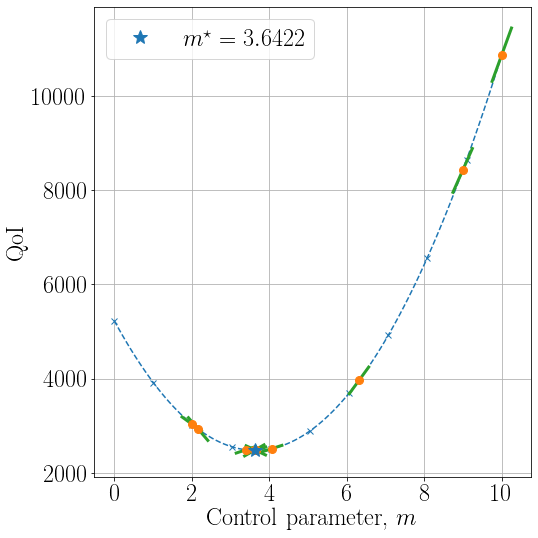

In [9]:
fig, axes = plt.subplots(figsize=(8, 8))
l = si.lagrange(op.control_trajectory[:3], op.functional_trajectory[:3])
dl = l.deriv()
print("Exact gradient at 10.0: {:.4f}".format(dl(10.0)))
print("Exact gradient at  5.0: {:.4f}".format(dl(5.0)))
l_min = -dl.coefficients[1]/dl.coefficients[0]
print("Minimiser of quadratic: {:.4f}".format(l_min))
xx = np.linspace(0, 10, 100)
axes.plot(xx, l(xx), '--x', color='C0', markevery=10)
delta_m = 0.25
for m, f, g in zip(op.control_trajectory, op.functional_trajectory, op.gradient_trajectory):
    x = np.array([m - delta_m, m + delta_m])
    axes.plot(x, g*(x-m) + f, '-', color='C2', linewidth=3)
axes.plot(op.control_trajectory, op.functional_trajectory, 'o', color='C1', markersize=8)
axes.plot(l_min, l(l_min), '*', markersize=14, color='C0', label=r"$m^\star={:.4f}$".format(l_min))
axes.set_xlabel(r"Control parameter, $m$")
axes.set_ylabel("QoI")
axes.grid(True)
axes.legend()
plt.tight_layout()
plt.savefig("plots/opt_progress_continuous_{:d}.pdf".format(level))